In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
"Setting up main Hyper-Parameters of the model"

n_qubits = 7  # Number of system qubits.
n_shots = 10 ** 6  # Number of quantum measurements.
tot_qubits = n_qubits + 1  # Addition of an ancillary qubit.
ancilla_idx = n_qubits  # Index of the ancillary qubit (last position).
steps = 40  # Number of optimization steps
eta = 0.8  # Learning rate
q_delta = 0.001  # Initial spread of random quantum weights
rng_seed = 0  # Seed for random number generator


In [3]:
#Fundemental Quantum Pauli Matrices 
Id = np.identity(2) #identity matrix of 2 rows
Z = np.array([[1, 0], [0, -1]]) 
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0,complex(0,1)],[-complex(0,1),0]])

In [4]:
gate_array = [Id,X,Y,Z]
gate_array_names = ["Id","X","Y","Z"]

### Linear System $Ax = b$

In [5]:
A_0 = np.identity(128)
A_1 = np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(X, Z), Id),Id),Id),Id),Id)
A_2 = np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(X, Id),Id),Id),Id),Id),Id)
A_3 = np.kron(np.kron(np.kron(np.kron(np.kron(np.kron(Z, Z), Id),Id),Id),Id),Id)

#Ax = b
A = 1 * A_0 + 0.2 * A_1 + 0.2 * A_2 
b = np.ones(128) / np.sqrt(128)

In [6]:
A

tensor([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]], requires_grad=True)

#### Get Coefficients of Linear Combination of Puali Matrices

In [7]:
counter = 0
i = 0

combination = gate_array

while counter < np.log2(len(A)) - 1:

    combination = np.kron(combination, gate_array)
    
    counter += 1

In [8]:
counter = 0
i = 0

combination_names = gate_array_names
temp_array_names = gate_array_names

for i in range(len(gate_array_names)):
    None

In [9]:
np.log2(len(A))

7.0

In [10]:
final_array = np.zeros((len(A),len(A)), dtype=complex)
c = []

for i in range(len(combination)):
    c_temp =  1/(len(A)) * np.matrix.trace(np.matmul(A,combination[i]))
    c.append(c_temp)
    final_array +=  c_temp * combination[i]

In [11]:
print(final_array.real)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [12]:
c = np.array(c)

In [13]:
c = c[c != 0]

In [14]:
c

tensor([1.0000000e+00+0.j, 2.0000000e-01+0.j, 6.9388939e-18+0.j,
        2.0000000e-01+0.j, 6.9388939e-18+0.j], requires_grad=True)

In [15]:
#controlled_gate_array = [1,CNOT,CY,CZ]
#Have to think of a clever way of combining the array to work out nicely - something that would reduce the zeros first

In [16]:
def U_b():
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

def CA(idx):
    """Controlled versions of the unitary components A_l of the problem matrix A."""
    if idx == 0:
        # Identity operation
        None

    elif idx == 1:
        qml.CNOT(wires=[ancilla_idx, 0])
    elif idx == 2:
        qml.CNOT(wires=[ancilla_idx, 0])
        qml.CZ(wires=[ancilla_idx, 1])
#     elif idx == 3:
#         qml.CZ(wires=[ancilla_idx, 0])
#         qml.CZ(wires=[ancilla_idx, 1])

In [17]:
def variational_block(weights):
    """Variational circuit mapping the ground state |0> to the ansatz state |x>."""
    
    # We first prepare an equal superposition of all the states of the computational basis.
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

    # A very minimal variational circuit.
    # just a single layer of qubit rotations around y
    # can make more complex 
    for idx, element in enumerate(weights):
        qml.RY(element, wires=idx)
        
        
    #return qml.expval(qml.PauliZ(0)) 
    ## don't actually want to return anything, just there to visualize for now
      
weights = np.random.random(size=3)
drawer = qml.draw(variational_block)

In [18]:
"Example of more complicated circuit using Pennylane StronglyEntaglingLayers, this is for later"
"Let's first get the RY circuit working"

dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def circuit(parameters):
    for idx in range(4):
        qml.Hadamard(wires=idx)
    
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(4))
    return qml.expval(qml.PauliZ(0))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=4)
weights = np.random.random(size=shape)

print(qml.draw(circuit, expansion_strategy="device")(weights))

0: ──H──Rot(0.99,0.52,0.88)─╭●───────╭X──Rot(0.90,0.53,0.24)─╭●────╭X────┤  <Z>
1: ──H──Rot(0.79,0.19,0.49)─╰X─╭●────│───Rot(0.85,0.93,0.89)─│──╭●─│──╭X─┤     
2: ──H──Rot(0.67,0.30,0.00)────╰X─╭●─│───Rot(0.24,0.15,0.12)─╰X─│──╰●─│──┤     
3: ──H──Rot(0.88,0.34,0.81)───────╰X─╰●──Rot(0.17,0.78,0.73)────╰X────╰●─┤     


In [19]:
dev_mu = qml.device("default.qubit", wires=tot_qubits)

@qml.qnode(dev_mu)
def local_hadamard_test(weights, l=None, lp=None, j=None, part=None):

    # First Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # For estimating the imaginary part of the coefficient "mu", we must add a "-i"
    # phase gate.
    if part == "Im" or part == "im":
        qml.PhaseShift(-np.pi / 2, wires=ancilla_idx)

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # Controlled application of the unitary component A_l of the problem matrix A.
    CA(l)

    # Adjoint of the unitary U_b associated to the problem vector |b>.
    # In this specific example Adjoint(U_b) = U_b.
    U_b()

    # Controlled Z operator at position j. If j = -1, apply the identity.
    if j != -1:
        qml.CZ(wires=[ancilla_idx, j])

    # Unitary U_b associated to the problem vector |b>.
    U_b()

    # Controlled application of Adjoint(A_lp).
    # In this specific example Adjoint(A_lp) = A_lp.
    CA(lp)

    # Second Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # Expectation value of Z for the ancillary qubit.
    return qml.expval(qml.PauliZ(wires=ancilla_idx))

In [34]:
print(qml.draw(local_hadamard_test)(weights=[1.2, 3.2, 0.7,0.4]))

   0: ──H──RY(1.20)──H──H─┤     
   1: ──H──RY(3.20)──H──H─┤     
   2: ──H──RY(0.70)──H──H─┤     
   3: ──H──RY(0.40)──H──H─┤     
   4: ──H──H─────────H────┤     
   5: ──H──H─────────H────┤     
   6: ──H──H─────────H────┤     
   7: ──H─╭●─────────H────┤  <Z>
None: ────╰Z──────────────┤     


In [21]:
def mu(weights, l=None, lp=None, j=None):
    """Generates the coefficients to compute the "local" cost function C_L."""

    mu_real = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Re")
    mu_imag = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Im")

    return mu_real + 1.0j * mu_imag

#### Local Cost Function
Need a function to estimate $<x|A^\dagger A|x>$

In [22]:
def psi_norm(weights):
    """Returns the normalization constant <psi|psi>, where |psi> = A |x>."""
    norm = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            norm = norm + c[l] * np.conj(c[lp]) * mu(weights, l, lp, -1)

    return abs(norm)

In [23]:
def cost_loc(weights):
    """Local version of the cost function. Tends to zero when A|x> is proportional to |b>."""
    mu_sum = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            for j in range(0, n_qubits):
                mu_sum = mu_sum + c[l] * np.conj(c[lp]) * mu(weights, l, lp, j)

    mu_sum = abs(mu_sum)

    # Cost function C_L
    return 0.5 - 0.5 * mu_sum / (n_qubits * psi_norm(weights))

#### Variational Optimization

In [24]:
#Intialize the weights with a fix seed

np.random.seed(rng_seed)
w = q_delta * np.random.randn(n_qubits, requires_grad=True)

In [25]:
#classical optimizer to minimize the cost function

opt = qml.GradientDescentOptimizer(eta)
#opt = qml.jacobian(eta)
#opt - qml.elementwise_grad(eta)
#opt = qml.holomorphic_grad(eta)

In [26]:
cost_history = []
for it in range(steps):
    w, cost = opt.step_and_cost(cost_loc, w)
    print("Step {:3d}       Cost_L = {:9.7f}".format(it, cost))
    cost_history.append(cost)

Step   0       Cost_L = 0.0000005
Step   1       Cost_L = 0.0000004
Step   2       Cost_L = 0.0000004
Step   3       Cost_L = 0.0000003
Step   4       Cost_L = 0.0000003
Step   5       Cost_L = 0.0000003
Step   6       Cost_L = 0.0000002
Step   7       Cost_L = 0.0000002
Step   8       Cost_L = 0.0000002
Step   9       Cost_L = 0.0000002
Step  10       Cost_L = 0.0000002
Step  11       Cost_L = 0.0000001
Step  12       Cost_L = 0.0000001
Step  13       Cost_L = 0.0000001
Step  14       Cost_L = 0.0000001
Step  15       Cost_L = 0.0000001
Step  16       Cost_L = 0.0000001
Step  17       Cost_L = 0.0000001
Step  18       Cost_L = 0.0000001
Step  19       Cost_L = 0.0000001
Step  20       Cost_L = 0.0000001
Step  21       Cost_L = 0.0000001
Step  22       Cost_L = 0.0000000
Step  23       Cost_L = 0.0000000
Step  24       Cost_L = 0.0000000
Step  25       Cost_L = 0.0000000
Step  26       Cost_L = 0.0000000
Step  27       Cost_L = 0.0000000
Step  28       Cost_L = 0.0000000
Step  29      

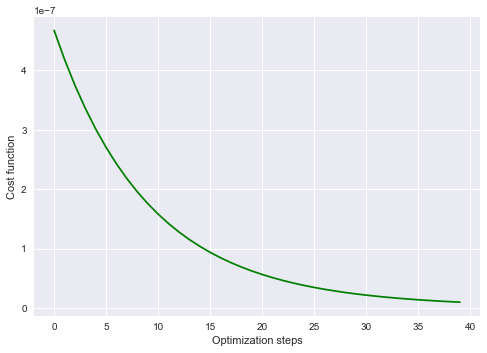

In [27]:
plt.style.use("seaborn")
plt.plot(cost_history, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

#### Preparation of Quantum Solution

In [28]:
dev_x = qml.device("default.qubit", wires=n_qubits, shots=n_shots)

@qml.qnode(dev_x)
def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()

In [29]:
raw_samples = prepare_and_sample(w)

# convert the raw samples (bit strings) into integers and count them
samples = []
for sam in raw_samples:
    samples.append(int("".join(str(bs) for bs in sam), base=2))

q_probs = np.bincount(samples) / n_shots


In [30]:
print("|<x|n>|^2=\n", q_probs)

|<x|n>|^2=
 [0.007759 0.007792 0.007841 0.007603 0.007705 0.007794 0.007775 0.007866
 0.007769 0.007897 0.007782 0.007923 0.007895 0.007888 0.007835 0.007927
 0.007811 0.007791 0.007756 0.007693 0.007794 0.007747 0.007716 0.007767
 0.007777 0.007706 0.007802 0.007763 0.007869 0.007776 0.007781 0.007896
 0.00784  0.00788  0.007765 0.007703 0.007889 0.007926 0.007837 0.007869
 0.007594 0.007635 0.007751 0.007792 0.007718 0.007901 0.007707 0.007813
 0.007761 0.00781  0.007822 0.007838 0.007713 0.007844 0.007895 0.007988
 0.007754 0.007878 0.00767  0.00775  0.007874 0.007754 0.00771  0.007756
 0.007814 0.007771 0.007802 0.007732 0.007904 0.00799  0.007849 0.008026
 0.007724 0.007906 0.007794 0.00787  0.007896 0.007881 0.007799 0.007616
 0.007881 0.007816 0.007782 0.007735 0.007902 0.007746 0.007827 0.007778
 0.007936 0.00763  0.007775 0.007714 0.007784 0.007877 0.007749 0.007841
 0.007712 0.007819 0.007832 0.00784  0.007912 0.007966 0.007887 0.007677
 0.007886 0.007964 0.007965 0.007862 0.

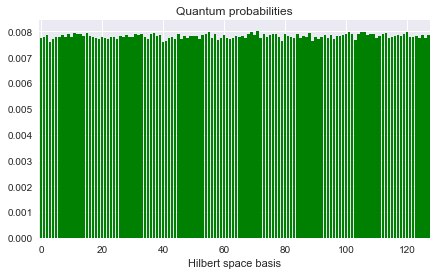

In [31]:
fig, ax2 = plt.subplots(1, figsize=(7, 4))

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()

In [32]:
A_inv = np.linalg.inv(A)
x = np.dot(A_inv, b)

In [33]:
c_probs = (x / np.linalg.norm(x)) ** 2
print("x_n^2 =\n", c_probs)

x_n^2 =
 [0.00527872 0.00527872 0.00527872 0.00527872 0.00527872 0.00527872
 0.00527872 0.00527872 0.00527872 0.00527872 0.00527872 0.00527872
 0.00527872 0.00527872 0.00527872 0.00527872 0.00527872 0.00527872
 0.00527872 0.00527872 0.00527872 0.00527872 0.00527872 0.00527872
 0.00527872 0.00527872 0.00527872 0.00527872 0.00527872 0.00527872
 0.00527872 0.00527872 0.01034628 0.01034628 0.01034628 0.01034628
 0.01034628 0.01034628 0.01034628 0.01034628 0.01034628 0.01034628
 0.01034628 0.01034628 0.01034628 0.01034628 0.01034628 0.01034628
 0.01034628 0.01034628 0.01034628 0.01034628 0.01034628 0.01034628
 0.01034628 0.01034628 0.01034628 0.01034628 0.01034628 0.01034628
 0.01034628 0.01034628 0.01034628 0.01034628 0.00527872 0.00527872
 0.00527872 0.00527872 0.00527872 0.00527872 0.00527872 0.00527872
 0.00527872 0.00527872 0.00527872 0.00527872 0.00527872 0.00527872
 0.00527872 0.00527872 0.00527872 0.00527872 0.00527872 0.00527872
 0.00527872 0.00527872 0.00527872 0.00527872 0.005278